# ESRB Rating Project

## Table Of Contents
<font size=3rem>
    
0 -**[ INTRO](#INTRODUCTION)<br>**
1 -**[ OBTAIN](#OBTAIN)**<br>
2 -**[ SCRUB](#SCRUB)**<br>
3 -**[ EXPLORE](#EXPLORE)**<br>
4 -**[ MODEL](#MODEL)**<br>
5 -**[ INTERPRET](#INTERPRET)**<br>
6 -**[ CONCLUSIONS & RECCOMENDATIONS](#Conclusions-&-Recommendations)<br>**
</font>
___

# INTRODUCTION

- Student: Cody Freese
- Pace: Self Paced
- Jeff Herman

In this notebook we will analyze ESRB Ratings and develop a model for predicting these ratings.

## Import Tools

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

import statsmodels as sm

import sklearn.preprocessing as preprocessing
from sklearn.decomposition import PCA

from sklearn.ensemble import (RandomForestClassifier,GradientBoostingClassifier,
                              BaggingClassifier,StackingClassifier,RandomForestRegressor)


from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split
from scipy import stats

from sklearn import tree

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import plot_confusion_matrix

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, KNeighborsRegressor

import warnings
warnings.filterwarnings("ignore")

In [61]:
#Classification Function
def classification(X_train, y_train,X_test,y_test, classifier):
    y_pred = classifier.predict(X_test)
    fig, ax = plt.subplots(figsize=(8,8))
    plot_confusion_matrix(estimator=classifier, X=X_test, y_true=y_test, ax=ax)
    plt.show()
    print(classification_report(y_test, y_pred))
    print(f'Accuracy:{round(accuracy_score(y_test,y_pred)*100, 2)}%')

In [62]:
def plot_game_consoles(df):
    # Combine titles into new category if they appear on both consoles.
    value_count_dct = {}
    for title, console in df[['title', 'console']].values:
        if title in value_count_dct and value_count_dct[title] != console:
            value_count_dct[title] = 'Available on Both'
        else:
            value_count_dct[title] = 'Xbox' if console == 1 else 'Playstation'
    engineered_series = pd.Series(value_count_dct).value_counts()
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    engineered_series.plot(kind='bar', ax=ax1)
    engineered_series.plot(kind='pie', ax=ax2)
    # SET TITLE AND STUFF HERE
    # ax1.set(title='', xlabel='', ylabel='')
    # ax2.set(title='', xlabel='', ylabel='')
    fig.tight_layout()
    plt.show()

# OBTAIN

In [63]:
# Import/Read
test_df = pd.read_csv('test_esrb.csv')
test_df.info()

train_df = pd.read_csv('Video_games_esrb_rating.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   title                     500 non-null    object
 1   console                   500 non-null    int64 
 2   alcohol_reference         500 non-null    int64 
 3   animated_blood            500 non-null    int64 
 4   blood                     500 non-null    int64 
 5   blood_and_gore            500 non-null    int64 
 6   cartoon_violence          500 non-null    int64 
 7   crude_humor               500 non-null    int64 
 8   drug_reference            500 non-null    int64 
 9   fantasy_violence          500 non-null    int64 
 10  intense_violence          500 non-null    int64 
 11  language                  500 non-null    int64 
 12  lyrics                    500 non-null    int64 
 13  mature_humor              500 non-null    int64 
 14  mild_blood                

In [64]:
#Combine the Train/Test CSVs into one
combined_csv = test_df.append(train_df)
combined_csv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2395 entries, 0 to 1894
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   title                     2395 non-null   object
 1   console                   2395 non-null   int64 
 2   alcohol_reference         2395 non-null   int64 
 3   animated_blood            2395 non-null   int64 
 4   blood                     2395 non-null   int64 
 5   blood_and_gore            2395 non-null   int64 
 6   cartoon_violence          2395 non-null   int64 
 7   crude_humor               2395 non-null   int64 
 8   drug_reference            2395 non-null   int64 
 9   fantasy_violence          2395 non-null   int64 
 10  intense_violence          2395 non-null   int64 
 11  language                  2395 non-null   int64 
 12  lyrics                    2395 non-null   int64 
 13  mature_humor              2395 non-null   int64 
 14  mild_blood              

# SCRUB

- Datatypes appear correct

## Pivot Table, Describe & Counts

In [65]:
#Organized table by Rating and Console
combined_csv.pivot_table(index=["esrb_rating","console"])

alcohol_reference  animated_blood     blood  \
esrb_rating console                                                
E           0                 0.035857        0.000000  0.000000   
            1                 0.033962        0.000000  0.000000   
ET          0                 0.129747        0.006329  0.000000   
            1                 0.061033        0.037559  0.000000   
M           0                 0.000000        0.000000  0.436275   
            1                 0.003663        0.000000  0.388278   
T           0                 0.039916        0.010504  0.430672   
            1                 0.073048        0.012594  0.387909   

                     blood_and_gore  cartoon_violence  crude_humor  \
esrb_rating console                                                  
E           0              0.000000          0.000000     0.003984   
            1              0.000000          0.000000     0.007547   
ET          0              0.000000          0.006329     0.069620   
            1              0.000000          0.117371     0.061033   
M           0              0.406863          0.000000     0.029412   
            1              0.578755          0.000000     0.003663   
T           0              0.084034          0.010504     0.048319   
            1              0.060453          0.040302     0.138539   

                     drug_reference  fantasy_violence  intense_violence  \
esrb_rating console                                                       
E           0              0.000000          0.000000          0.000000   
            1              0.000000          0.000000          0.000000   
ET          0              0.012658          0.715190          0.085443   
            1              0.037559          0.582160          0.084507   
M           0              0.053922          0.117647          0.186275   
            1              0.069597          0.095238          0.315018   
T           0              0.056723          0.222689          0.132353   
            1              0.032746          0.113350          0.075567   

                     language  ...  partial_nudity  sexual_content  \
esrb_rating console            ...                                   
E           0        0.000000  ...        0.000000        0.000000   
            1        0.000000  ...        0.000000        0.000000   
ET          0        0.072785  ...        0.003165        0.000000   
            1        0.070423  ...        0.000000        0.000000   
M           0        0.161765  ...        0.068627        0.112745   
            1        0.172161  ...        0.069597        0.073260   
T           0        0.195378  ...        0.027311        0.050420   
            1        0.148615  ...        0.017632        0.020151   

                     sexual_themes  simulated_gambling  strong_janguage  \
esrb_rating console                                                       
E           0             0.000000            0.000000         0.000000   
            1             0.000000            0.000000         0.000000   
ET          0             0.000000            0.009494         0.000000   
            1             0.000000            0.004695         0.004695   
M           0             0.230392            0.142157         0.500000   
            1             0.117216            0.124542         0.509158   
T           0             0.039916            0.048319         0.008403   
            1             0.040302            0.120907         0.010076   

                     strong_sexual_content  suggestive_themes  use_of_alcohol  \
esrb_rating console                                                             
E           0                     0.000000           0.000000        0.000000   
            1                     0.000000           0.000000        0.000000   
ET          0                     0.006329           0.075949        0.025316   
            1                  

In [66]:
#Checking values
combined_csv.describe()

,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,intense_violence,...,partial_nudity,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence
count,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,...,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.000000,2395.00000,2395.000000,2395.000000
mean,0.479332,0.050522,0.008351,0.231315,0.127349,0.020042,0.051357,0.034238,0.230063,0.109395,...,0.022547,0.031315,0.047599,0.057620,0.104384,0.038831,0.108977,0.03048,0.022965,0.114823
std,0.499677,0.219065,0.091019,0.421762,0.333433,0.140172,0.220771,0.181878,0.420961,0.312199,...,0.148485,0.174205,0.212961,0.233072,0.305822,0.193232,0.311675,0.17194,0.149822,0.318874
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [67]:
#Get a count of possible duplicate titles Yes/No
for column in combined_csv:
    print(combined_csv[column].value_counts())

SHINY                                   2
South Park: The Stick of Truth          2
Pillars of Eternity                     2
3D MiniGolf                             2
BLACKHOLE: Complete Edition             2
                                       ..
Yakuza 3                                1
Rogue Legacy                            1
Phantom Trigger                         1
Ninjin: Clash of Carrots                1
The Inner World - The Last Wind Monk    1
Name: title, Length: 2332, dtype: int64
0    1247
1    1148
Name: console, dtype: int64
0    2274
1     121
Name: alcohol_reference, dtype: int64
0    2375
1      20
Name: animated_blood, dtype: int64
0    1841
1     554
Name: blood, dtype: int64
0    2090
1     305
Name: blood_and_gore, dtype: int64
0    2347
1      48
Name: cartoon_violence, dtype: int64
0    2272
1     123
Name: crude_humor, dtype: int64
0    2313
1      82
Name: drug_reference, dtype: int64
0    1844
1     551
Name: fantasy_violence, dtype: int64
0    2133
1    

In [68]:
pd.DataFrame(combined_csv["title"].value_counts()[combined_csv["title"].value_counts() > 1]).index
#Duplicate Titles across platforms

Index(['SHINY', 'South Park: The Stick of Truth', 'Pillars of Eternity',
       '3D MiniGolf', 'BLACKHOLE: Complete Edition', 'Pineview Drive',
       'Lethal League', 'RAID: WORLD WAR II', 'Late Shift', 'Destiny 2',
       'Kill The Bad Guy', 'The Long Dark', '88 Heroes',
       'Momodora: Reverie Under the Moonlight',
       'Paranormal Activity: The Lost Soul', 'The Inner World',
       'River City Melee: Battle Royal Special', 'Future Unfolding', 'Aaero',
       'Human Fall Flat', 'Hellblade: Senua's Sacrifice', 'Revenant Saga',
       'Jak II', 'Children of Zodiarcs', 'Cosmic Star Heroine',
       'Super GunWorld 2', 'ADK DAMASHII', 'Serial Cleaner',
       'Jak X: Combat Racing', 'Duck Game', 'Crawl', 'Thimbleweed Park',
       'forma.8', 'Night Trap - 25th Anniversary Edition', 'BUTCHER', 'Jak 3',
       'Windjammers', 'Narcosis', 'Elite Dangerous: Legendary Edition',
       'Kero Blaster', '2064: Read Only Memories', 'Surf World Series',
       'Island Flight Simulator', 'Unbox

In [69]:
len(pd.DataFrame(combined_csv["title"].value_counts()[combined_csv["title"].value_counts() > 1]).index)

63

In [70]:
# 63 games that exist on both platforms but my function doens't catch

In [71]:
combined_csv[combined_csv['title']=="South Park: The Stick of Truth"]
#Variables don't match for the same game/sometimes same console

,title,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,...,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating
16,South Park: The Stick of Truth,1,0,0,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,M
1514,South Park: The Stick of Truth,1,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,M


# EXPLORE

## EDA by Platform

In [72]:
#Where Duplicated Titles
combined_csv.drop_duplicates(inplace=True)
#Rows where titles are duplicated, consoles are different AND will drop row if the row is an exact duplicate
combined_csv[combined_csv['title'].duplicated(keep=False)]

,title,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,...,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating
0,Still Time,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,T
2,The Metronomicon: Slay the Dance Floor,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,T
16,South Park: The Stick of Truth,1,0,0,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,M
22,Mages of Mystralia,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,ET
31,Super Comboman: Smash Edition,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,ET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1720,Crawl,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,T
1810,The Inner World,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,T
1833,RAID: WORLD WAR II,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,M
1885,Pillars of Eternity,1,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,M


In [73]:
value_count_dct = {}
for title, console in combined_csv[['title', 'console']].values:
    if title in value_count_dct and value_count_dct[title] != console:
        value_count_dct[title] = 'Available on Both'
    else:
        value_count_dct[title] = console

<AxesSubplot:>

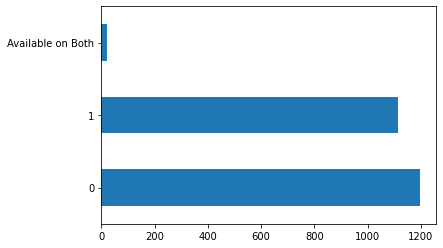

In [74]:
pd.Series(value_count_dct).value_counts().plot(kind='barh')

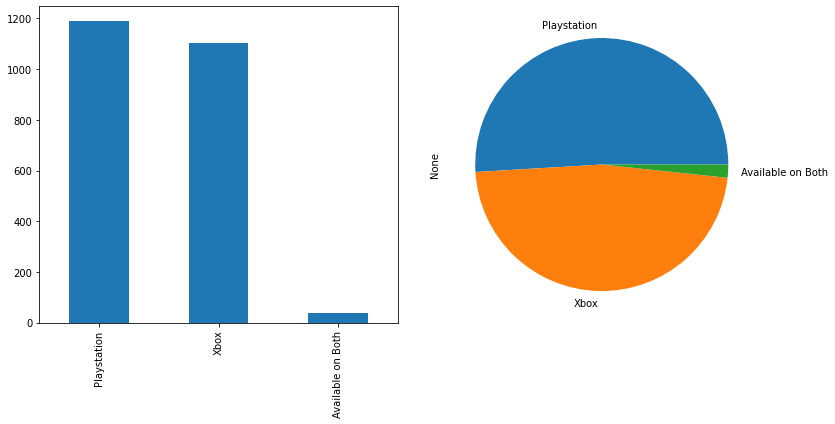

In [75]:
plot_game_consoles(combined_csv)

## Correlation

In [76]:
# One Hot Encoding Ratings
mapp = { 'E' : 0,
          'ET': 1,
          'T' : 2,
          'M' : 3,}

combined_csv['esrb_rating'] = combined_csv['esrb_rating'].map(mapp)

In [77]:
# subjective_corr = combined_csv.corr()
# subjective_corr[np.abs(subjective_corr)<.2]=0
# mask = np.zeros_like(subjective_corr, dtype=np.bool)

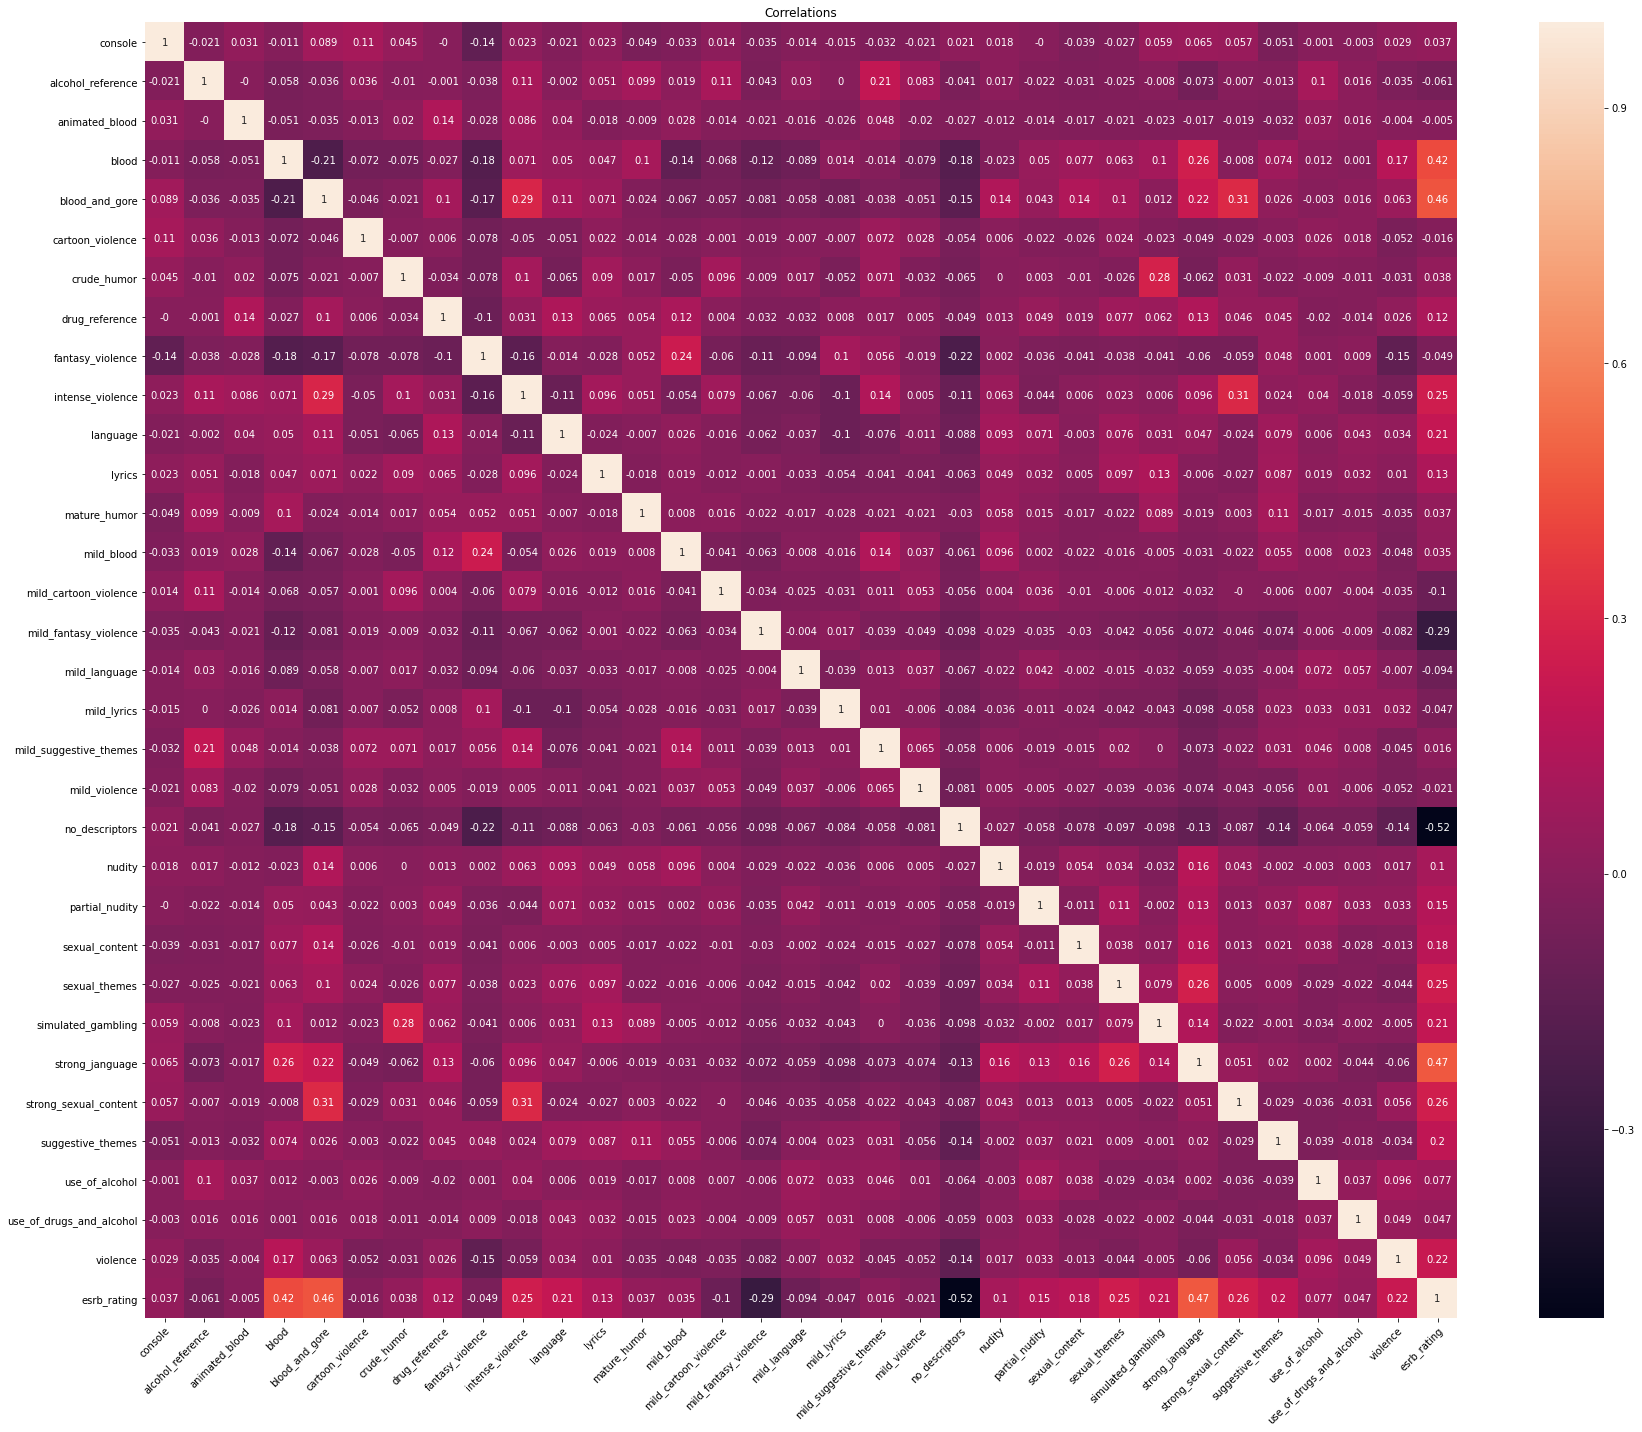

In [78]:
fig, ax = plt.subplots(figsize=(25,20))
corr = combined_csv.corr().round(3)
sb.heatmap(corr, annot=True,ax=ax, mask=mask)
plt.setp(ax.get_xticklabels(), 
         rotation=45, 
         ha="right",
         rotation_mode="anchor")
ax.set_title('Correlations')
fig.tight_layout()

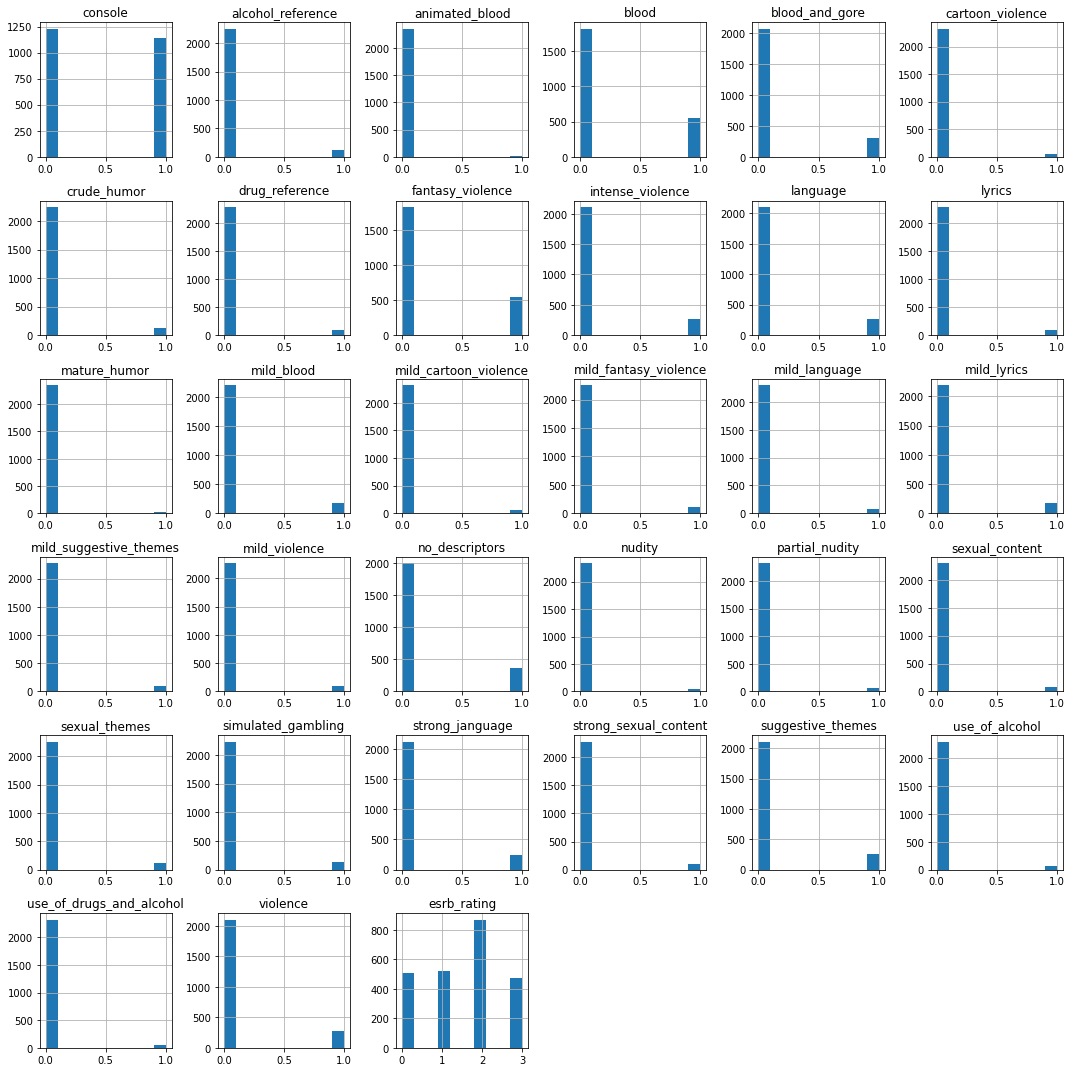

In [79]:
combined_csv.hist(figsize=(15,15))
plt.tight_layout()

# MODEL

## Train Test Split

In [80]:
#Train Test Split
X = combined_csv.drop(['esrb_rating', 'title'],1)

y = combined_csv[['esrb_rating']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 354681)

## Initial Model

### Decision Tree

In [81]:
#Fit decision tree, initial classifier, no parameters
dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [82]:
#Initial dtc training score
dtc.score(X_train, y_train)

0.9282700421940928

In [83]:
#Initial dtc test score
dtc.score(X_test, y_test)

0.8328651685393258

In [84]:
y_preds = dtc.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_preds))

Accuracy:  0.8328651685393258


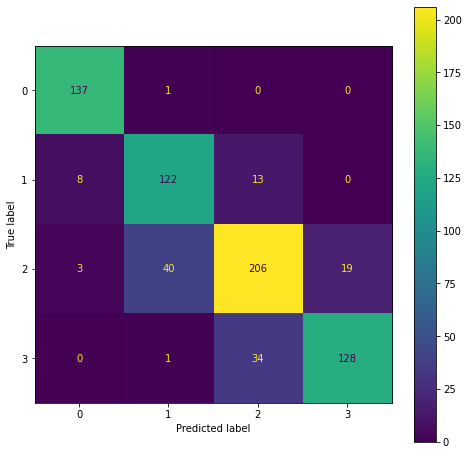

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       138
           1       0.74      0.85      0.79       143
           2       0.81      0.77      0.79       268
           3       0.87      0.79      0.83       163

    accuracy                           0.83       712
   macro avg       0.84      0.85      0.84       712
weighted avg       0.83      0.83      0.83       712

Accuracy:83.29%


In [85]:
#Confusion matrix, initial dtc classifier
classification(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    classifier=dtc)

- Model on training set
    - Numbers on the Bottom/Left indicate failure based off of recall metric to catch harmful content from falling into lower ESRB ratings
    - Numbers on Top/Right indicate a game receiving a stricter rating than is required, while this could impact outreach and sales, questionable content is caught from lower ratings

### KNN

In [92]:
##Fit knn initial classifier, no parameters
knn = KNeighborsClassifier()

knn.fit(X_train, y_train)

KNeighborsClassifier()

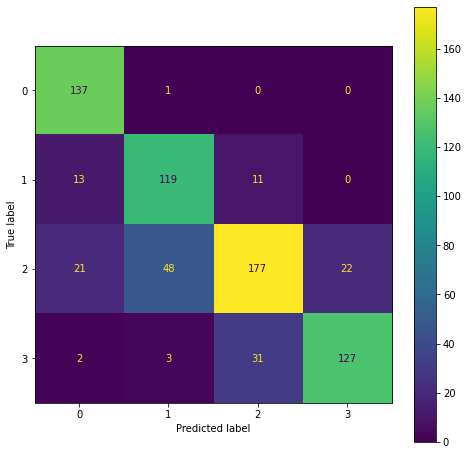

              precision    recall  f1-score   support

           0       0.79      0.99      0.88       138
           1       0.70      0.83      0.76       143
           2       0.81      0.66      0.73       268
           3       0.85      0.78      0.81       163

    accuracy                           0.79       712
   macro avg       0.79      0.82      0.79       712
weighted avg       0.79      0.79      0.78       712

Accuracy:78.65%


In [93]:
#Confusion matrix, initial knn classifier
classification(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    classifier=knn)

- Model on training set
    - Numbers on the Bottom/Left indicate failure based off of recall metric to catch harmful content from falling into lower ESRB ratings
    - Numbers on Top/Right indicate a game receiving a stricter rating than is required, while this could impact outreach and sales, questionable content is caught from lower ratings

### Random Forest

In [94]:
##Fit random forest initial classifier, no parameters
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

RandomForestClassifier()

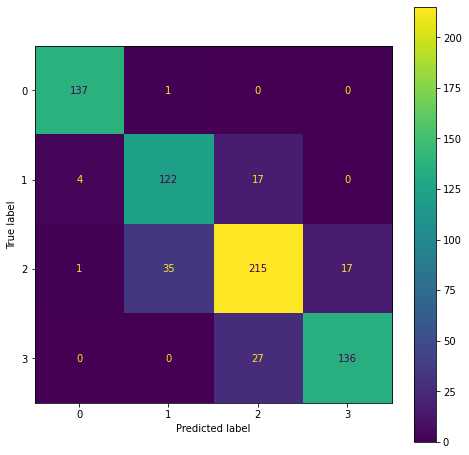

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       138
           1       0.77      0.85      0.81       143
           2       0.83      0.80      0.82       268
           3       0.89      0.83      0.86       163

    accuracy                           0.86       712
   macro avg       0.86      0.87      0.87       712
weighted avg       0.86      0.86      0.86       712

Accuracy:85.67%


In [95]:
#Confusion matrix, initial rfc classifier
classification(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    classifier=rfc)

- Model on training set
    - Numbers on the Bottom/Left indicate failure based off of recall metric to catch harmful content from falling into lower ESRB ratings
    - Numbers on Top/Right indicate a game receiving a stricter rating than is required, while this could impact outreach and sales, questionable content is caught from lower ratings

- DTC              precision    recall  f1-score   support

           0       0.93      0.97      0.95       161
           1       0.78      0.87      0.82       155
           2       0.87      0.79      0.82       271
           3       0.87      0.87      0.87       132
           
           
- KNN              precision    recall  f1-score   support

           0       0.85      0.98      0.91       161
           1       0.69      0.77      0.73       155
           2       0.80      0.70      0.75       271
           3       0.89      0.83      0.86       132
           
- RFC              precision    recall  f1-score   support

           0       0.91      0.97      0.94       161
           1       0.77      0.82      0.79       155
           2       0.86      0.78      0.82       271
           3       0.88      0.90      0.89       132

- While all the models appear to perform well in the training set, lets see how it works further refined and applied to the test set

# 1st Refined Models

### Decision Tree Refined Model

In [96]:
##Fit decision tree, applying parameters to refine search
dtc_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [97]:
#GridSearchCV on DTC
dtc_grid_search = GridSearchCV(dtc, dtc_param_grid, cv=3, return_train_score=True)

dtc_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True)

In [98]:
#Search for best estimator
bestdtc = dtc_grid_search.best_estimator_

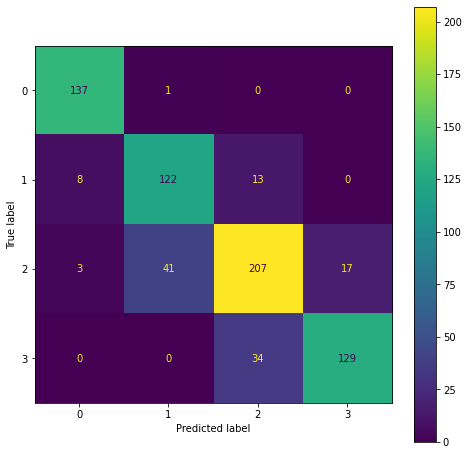

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       138
           1       0.74      0.85      0.79       143
           2       0.81      0.77      0.79       268
           3       0.88      0.79      0.83       163

    accuracy                           0.84       712
   macro avg       0.84      0.85      0.85       712
weighted avg       0.84      0.84      0.83       712

Accuracy:83.57%


In [99]:
#Confusion matrix
classification(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    classifier=bestdtc)

- Model on training set
    - Numbers on the Bottom/Left indicate failure based off of recall metric to catch harmful content from falling into lower ESRB ratings
    - Numbers on Top/Right indicate a game receiving a stricter rating than is required, while this could impact outreach and sales, questionable content is caught from lower ratings

In [100]:
#search for best parameters
dtc_grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [101]:
bestdtc.score(X_test,y_test)

0.8356741573033708

In [102]:
bestdtc.score(X_train,y_train)

0.9282700421940928

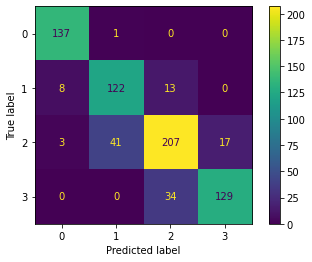

In [103]:
plot_confusion_matrix(estimator=bestdtc, X=X_test, y_true=y_test)

- While DTC model appears to predict E ratings, it fails to catch 80 games that should be rated M and allow them to fall into Everyone rating
- Model appears especially bad at catching Mature content specifically

### KNN Refined Model

In [104]:
#Fit knn, applying parameters to refine search
knn_param_grid = {
    'n_neighbors': [3,5,7],
    'weights': ['uniform','distance'],
    'algorithm': ['ball_tree','kd_tree','brute'],
    'p':[1,2,3]
}

In [105]:
#GridSearch on Knn
knn_grid_search = GridSearchCV(knn, knn_param_grid, cv=3, return_train_score=True)

knn_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 7], 'p': [1, 2, 3],
                         'weights': ['uniform', 'distance']},
             return_train_score=True)

In [106]:
#best estimator
bestknn = knn_grid_search.best_estimator_

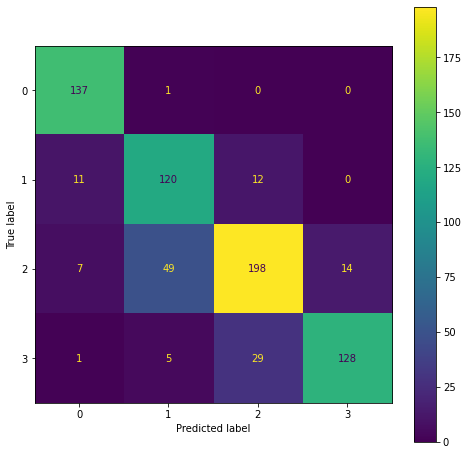

              precision    recall  f1-score   support

           0       0.88      0.99      0.93       138
           1       0.69      0.84      0.75       143
           2       0.83      0.74      0.78       268
           3       0.90      0.79      0.84       163

    accuracy                           0.82       712
   macro avg       0.82      0.84      0.83       712
weighted avg       0.83      0.82      0.82       712

Accuracy:81.88%


In [107]:
#Knn confusion matrix
classification(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    classifier=bestknn)

- Model on training set
    - Numbers on the Bottom/Left indicate failure based off of recall metric to catch harmful content from falling into lower ESRB ratings
    - Numbers on Top/Right indicate a game receiving a stricter rating than is required, while this could impact outreach and sales, questionable content is caught from lower ratings

In [108]:
#search for best parameters
knn_grid_search.best_params_

{'algorithm': 'ball_tree', 'n_neighbors': 3, 'p': 3, 'weights': 'distance'}

In [109]:
#knn model test score
bestknn.score(X_test,y_test)

0.8188202247191011

In [110]:
#knn model training score
bestknn.score(X_train,y_train)

0.9276672694394213

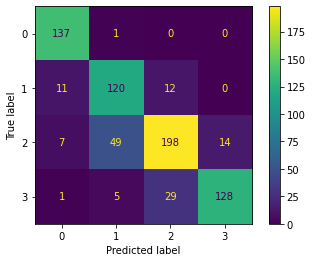

In [111]:
#confusion matrix results for trained data against test
plot_confusion_matrix(estimator=bestknn, X=X_test, y_true=y_test)

- While KNN model appears to predict E ratings, it fails to catch 80 games that should be rated M and allow them to fall into Everyone rating
- Model appears especially bad at catching Mature content also

### Random Forest Refined

In [112]:
##Fit random forest, applying parameters to refine search
rfc_param_grid = {
    'n_estimators': [50,100],
    'criterion': ['gini','entropy'],
    'max_depth': [None,3, 5, 7],
    'min_samples_split': [1, 2, 4, 6],
    'min_samples_leaf': [1,2,3],
    'max_features': [None,'sqrt','log2'],
    'random_state': [7],
    
}

In [113]:
#Gridsearch on rfc
rfc_grid_search = GridSearchCV(rfc, rfc_param_grid, cv=3,n_jobs=10, return_train_score=True)

rfc_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=10,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 5, 7],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 4, 6],
                         'n_estimators': [50, 100], 'random_state': [7]},
             return_train_score=True)

In [114]:
#best estimator
bestrfc = rfc_grid_search.best_estimator_

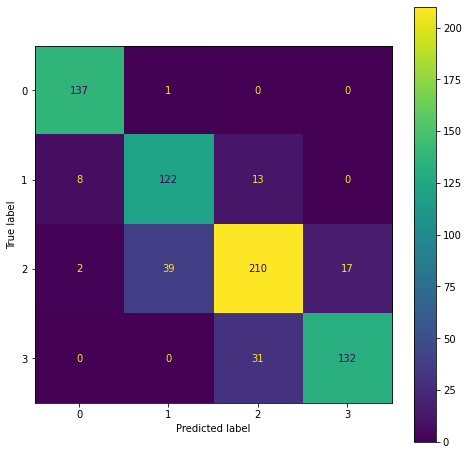

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       138
           1       0.75      0.85      0.80       143
           2       0.83      0.78      0.80       268
           3       0.89      0.81      0.85       163

    accuracy                           0.84       712
   macro avg       0.85      0.86      0.85       712
weighted avg       0.85      0.84      0.84       712

Accuracy:84.41%


In [115]:
#rfc confusion matrix
classification(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    classifier=bestrfc)

- Model on training set
    - Numbers on the Bottom/Left indicate failure based off of recall metric to catch harmful content from falling into lower ESRB ratings
    - Numbers on Top/Right indicate a game receiving a stricter rating than is required, while this could impact outreach and sales, questionable content is caught from lower ratings

In [116]:
#best parameter
rfc_grid_search.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 50,
 'random_state': 7}

In [117]:
#rfc model test score
bestrfc.score(X_test,y_test)

0.8441011235955056

In [118]:
#rfc model training score
bestrfc.score(X_train,y_train)

0.9204339963833634

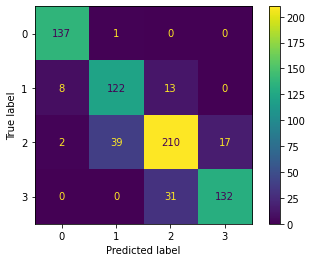

In [119]:
#confusion matrix results for trained data against test
plot_confusion_matrix(estimator=bestrfc, X=X_test, y_true=y_test)

- While RFC model appears to predict E ratings, it fails to catch 80 games that should be rated M and allow them to fall into Everyone rating
- Model appears especially bad at catching Mature content specifically

# 2nd Refined Models

### Decision Tree Refined

In [120]:
##Fit decision tree, applying parameters to refine search
dtc_para_grid = {
    'criterion': 'gini',
    'max_depth': None,
    'min_samples_leaf': 1,
    'min_samples_split': 2
}

In [121]:
#Search for best estimator
bestdtc = dtc_grid_search.best_estimator_

In [122]:
#GridSearchCV on DTC
dtc_grid_search = GridSearchCV(dtc, dtc_param_grid, cv=3, return_train_score=True)

dtc_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True)

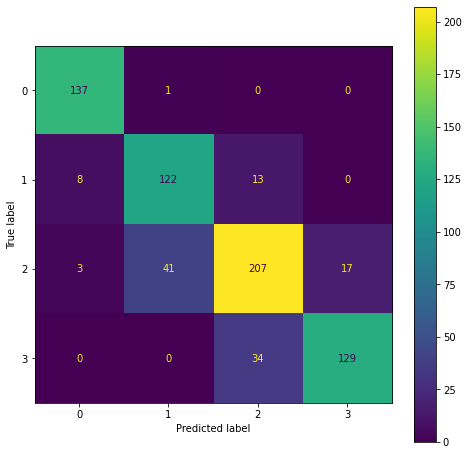

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       138
           1       0.74      0.85      0.79       143
           2       0.81      0.77      0.79       268
           3       0.88      0.79      0.83       163

    accuracy                           0.84       712
   macro avg       0.84      0.85      0.85       712
weighted avg       0.84      0.84      0.83       712

Accuracy:83.57%


In [123]:
#Confusion matrix
classification(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    classifier=bestdtc)

- Model on training set
    - Numbers on the Bottom/Left indicate failure based off of recall metric to catch harmful content from falling into lower ESRB ratings
    - Numbers on Top/Right indicate a game receiving a stricter rating than is required, while this could impact outreach and sales, questionable content is caught from lower ratings

In [124]:
#dtc model test score
bestdtc.score(X_test,y_test)

0.8356741573033708

In [125]:
#dtc model training score
bestdtc.score(X_train,y_train)

0.9282700421940928

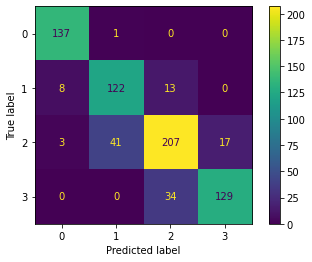

In [126]:
#confusion matrix results for trained data against test
plot_confusion_matrix(estimator=bestdtc, X=X_test, y_true=y_test)

### KNN Refined Model

In [127]:
##Fit knn, applying parameters to refine search
knn_para_grid = {
    'algorithm': 'brute',
    'n_neighbors': 5,
    'p': 1,
    'weights': 'distance'
}

In [128]:
#GridSearch on Knn
knn_grid_search = GridSearchCV(knn, knn_param_grid, cv=3, return_train_score=True)

knn_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 7], 'p': [1, 2, 3],
                         'weights': ['uniform', 'distance']},
             return_train_score=True)

In [129]:
#Search for best estimator
bestknn = dtc_grid_search.best_estimator_

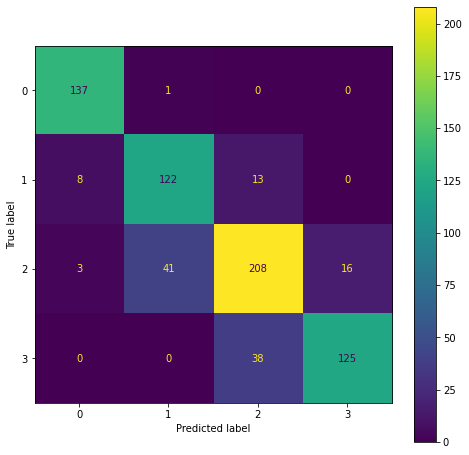

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       138
           1       0.74      0.85      0.79       143
           2       0.80      0.78      0.79       268
           3       0.89      0.77      0.82       163

    accuracy                           0.83       712
   macro avg       0.84      0.85      0.84       712
weighted avg       0.83      0.83      0.83       712

Accuracy:83.15%


In [130]:
#Knn confusion matrix
classification(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    classifier=bestknn)

- Model on training set
    - Numbers on the Bottom/Left indicate failure based off of recall metric to catch harmful content from falling into lower ESRB ratings
    - Numbers on Top/Right indicate a game receiving a stricter rating than is required, while this could impact outreach and sales, questionable content is caught from lower ratings

In [131]:
#rfc model test score
bestrfc.score(X_test,y_test)

0.8441011235955056

In [132]:
#rfc model training score
bestrfc.score(X_train,y_train)

0.9204339963833634

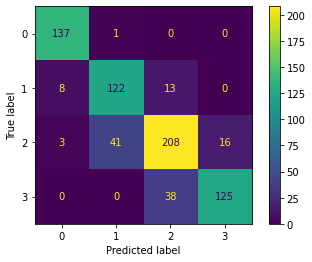

In [133]:
#confusion matrix results for trained data against test
plot_confusion_matrix(estimator=bestknn, X=X_test, y_true=y_test)

### Random Forest Refined

In [134]:
##Fit rfc, applying parameters to refine search
rfc_para_grid = {
    'criterion':'gini',
    'max_depth':None,
    'max_features':'sqrt',
    'min_samples_leaf':1,
    'min_samples_split':2,
    'n_estimators':100,
    'random_state':7
}

In [135]:
#GridSearch on rfc
rfc_grid_search = GridSearchCV(rfc, rfc_param_grid, cv=3,n_jobs=10, return_train_score=True)

rfc_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=10,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 5, 7],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 4, 6],
                         'n_estimators': [50, 100], 'random_state': [7]},
             return_train_score=True)

In [136]:
#best estimator
bestrfc = rfc_grid_search.best_estimator_

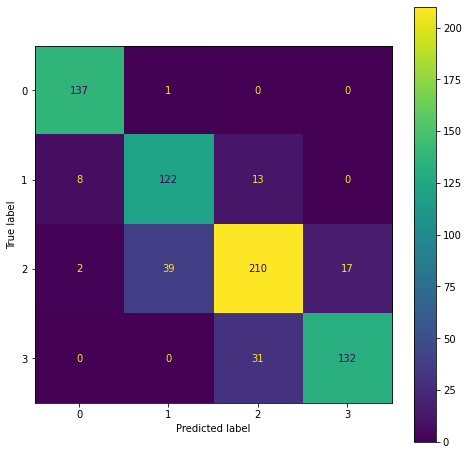

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       138
           1       0.75      0.85      0.80       143
           2       0.83      0.78      0.80       268
           3       0.89      0.81      0.85       163

    accuracy                           0.84       712
   macro avg       0.85      0.86      0.85       712
weighted avg       0.85      0.84      0.84       712

Accuracy:84.41%


In [137]:
#rfc confusion matrix
classification(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    classifier=bestrfc)

- Model on training set
    - Numbers on the Bottom/Left indicate failure based off of recall metric to catch harmful content from falling into lower ESRB ratings
    - Numbers on Top/Right indicate a game receiving a stricter rating than is required, while this could impact outreach and sales, questionable content is caught from lower ratings

In [138]:
#rfc model test score
bestrfc.score(X_test,y_test)

0.8441011235955056

In [139]:
#rfc model training score
bestrfc.score(X_train,y_train)

0.9204339963833634

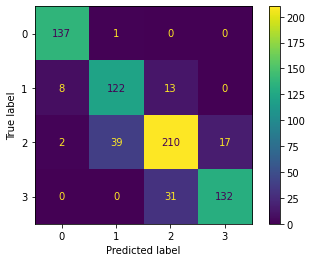

In [140]:
#confusion matrix results for trained data against test
plot_confusion_matrix(estimator=bestrfc, X=X_test, y_true=y_test)

# INTERPRET

## Decision Tree Feature Importances

In [141]:
#What features carry the most weight
dtc.feature_importances_

array([0.01914471, 0.01225228, 0.00534034, 0.06691635, 0.07448009,
       0.00910777, 0.02657301, 0.00956796, 0.10724753, 0.02259399,
       0.03755729, 0.01345902, 0.0017683 , 0.01679918, 0.0069748 ,
       0.07029045, 0.0073931 , 0.01292775, 0.01828643, 0.01504046,
       0.15477959, 0.00259561, 0.00601928, 0.00769069, 0.02064179,
       0.0204625 , 0.1377079 , 0.01786863, 0.03110202, 0.01367441,
       0.00352114, 0.03021558])

In [142]:
Feature_Importances=pd.DataFrame({"feature":X_train.columns,"importance":dtc.feature_importances_})
Feature_Importances.sort_values("importance")

,feature,importance
12,mature_humor,0.001768
21,nudity,0.002596
30,use_of_drugs_and_alcohol,0.003521
2,animated_blood,0.005340
22,partial_nudity,0.006019
14,mild_cartoon_violence,0.006975
16,mild_language,0.007393
23,sexual_content,0.007691
5,cartoon_violence,0.009108
7,drug_reference,0.009568


## Random Forest Feature Importances

In [143]:
#What features carry the most weight
rfc.feature_importances_

array([0.02561796, 0.01673953, 0.00619631, 0.09721485, 0.07750057,
       0.01432552, 0.02510537, 0.00882863, 0.10379562, 0.02647296,
       0.03833269, 0.01127582, 0.00442787, 0.02385273, 0.0098167 ,
       0.04026868, 0.008811  , 0.01511384, 0.01676556, 0.0195784 ,
       0.11551397, 0.00299106, 0.00895506, 0.00862865, 0.02048952,
       0.0213842 , 0.11405201, 0.02002899, 0.03337807, 0.01358929,
       0.00727472, 0.04367387])

In [144]:
Feature_Importances=pd.DataFrame({"feature":X_train.columns,"importance":rfc.feature_importances_})
Feature_Importances.sort_values("importance")

,feature,importance
21,nudity,0.002991
12,mature_humor,0.004428
2,animated_blood,0.006196
30,use_of_drugs_and_alcohol,0.007275
23,sexual_content,0.008629
16,mild_language,0.008811
7,drug_reference,0.008829
22,partial_nudity,0.008955
14,mild_cartoon_violence,0.009817
11,lyrics,0.011276


In [145]:
combined_csv.groupby("esrb_rating")["no_descriptors"].value_counts()
#How many No Descriptors exist in each category

esrb_rating  no_descriptors
0            1                 311
             0                 196
1            0                 504
             1                  16
2            0                 826
             1                  42
3            0                 472
             1                   4
Name: no_descriptors, dtype: int64

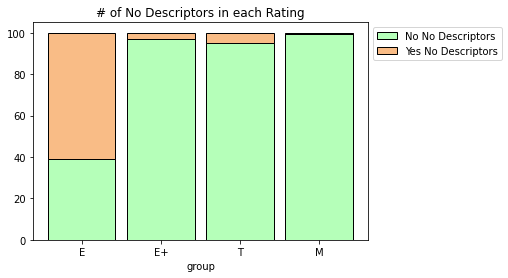

In [146]:
# Data
r = [0,1,2,3]
No_Descriptor = {'E': [201, 512, 830, 473], 'ET': [315, 17, 43, 4]}
df = pd.DataFrame(No_Descriptor)

#From raw value to percentage
totals = [i+j for i,j in zip(df['E'], df['ET'])]
greenBars = [i / j * 100 for i,j in zip(df['E'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df['ET'], totals)]
# plot
barWidth = 0.85
names = ('E','E+','T','M')
# Create green Bars
plt.bar(r, greenBars, color='#b5ffb9', edgecolor='black', width=barWidth, label="No No Descriptors")
# Create orange Bars
plt.bar(r, orangeBars,bottom=greenBars, color='#f9bc86', edgecolor='black', width=barWidth, label="Yes No Descriptors")
# Custom x axis
plt.xticks(r, names)
plt.xlabel("group")
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
# Show graphic
plt.title(label='# of No Descriptors in each Rating')
plt.show()

- No Descriptors has a significant impact on the E ratings

# CONCLUSIONS & RECCOMENDATIONS

- Next steps
    - Research what makes up 'No Descriptors' category to futher analyze its impact on E Rating
    - Explore further correlations and groupings to improve models